# Train, run and evaluate one single SVR

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
from qa_summer.QSVR import QSVR
from dimod import ExactSolver
from sklearn.preprocessing import QuantileTransformer
from sklearn.model_selection import train_test_split
from utils import nb_utils
from joblib import dump, load
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import datetime
from random import randint

In [9]:
save = False # set to True to save the trained QSVR
df_info = nb_utils.get_df_info('mlpf')
df = pd.read_csv(df_info['df_path'])
df = df.drop(df[df.loss_99 == df.loss_99.max()].index)
df.head()

,bin_size,dropout,lr,n_glayers_id,n_glayers_reg,output_dim,weight_decay,loss_0,loss_1,loss_2,...,loss_90,loss_91,loss_92,loss_93,loss_94,loss_95,loss_96,loss_97,loss_98,loss_99
0,64.0,0.449385,0.009435,0.0,3.0,256.0,0.000044,484.088806,459.301514,455.343811,...,447.429688,447.619354,447.439209,447.404633,447.566406,447.313049,447.398407,447.414673,447.228088,447.501160
1,64.0,0.089148,0.000039,4.0,2.0,32.0,0.001984,533.915894,530.372620,531.893738,...,529.851562,529.258301,529.493103,530.038452,529.909546,528.990479,528.480469,528.026733,528.153503,528.540161
2,16.0,0.486632,0.000276,2.0,4.0,64.0,0.000065,523.189575,465.601929,461.147034,...,450.873169,450.938354,450.910492,450.801270,450.888123,450.814850,450.916229,450.814087,450.843414,450.758148
3,32.0,0.172208,0.000042,3.0,2.0,64.0,0.000007,543.986328,484.317230,472.085449,...,448.064484,448.042389,447.977570,447.926147,447.885559,447.846802,447.796967,447.781799,447.710571,447.668335
4,32.0,0.172208,0.000042,3.0,2.0,64.0,0.000007,543.924561,484.485809,472.445312,...,448.215912,544.031372,484.386292,472.220398,467.484924,464.688690,462.955078,461.424591,460.127716,459.114685


In [11]:
# Select Features and target
curve = nb_utils.get_curve(df_info=df_info, known_curve=0.25, df=df)
# Use only Downsampled learning curve without hps
X = curve[:,[i for i in range(0,curve.shape[1],2)]] 
y = nb_utils.get_target(df_info,df)

In [12]:
# Scale data
x_scaler = QuantileTransformer(n_quantiles=50,random_state=0)
X = x_scaler.fit_transform(X)
y_scaler =  QuantileTransformer(n_quantiles=50,random_state=0)
y = y_scaler.fit_transform(y.reshape(-1, 1)).ravel()

In [13]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)
X_train = X_train[:79,:]
y_train = y_train[:79]
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((79, 13), (79,), (148, 13), (148,))

In [14]:
# calculate sklearn default values for C and gamma
n_features = X_train.shape[1]
gamma = 1/(n_features*X_train.var())
C = 1.0
print("Gamma = " + str(gamma))
print("C = " + str(C))

Gamma = 1.070349905089307
C = 1.0


In [16]:
#try to optimize regressor hps
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVR
best, C_best, epsilon_best, gamma_best = -100, None, None, None
for _ in range(1000):
	C = np.exp(np.random.uniform(np.log(1e-3),np.log(100.0)))
	gamma = np.exp(np.random.uniform(np.log(1e-3),np.log(10.0)))
	epsilon = np.exp(np.random.uniform(np.log(1e-3),np.log(1)))
	model = SVR(C=C,epsilon=epsilon,gamma=gamma)
	cvs, __ = nb_utils.small_train_r2_cv(model, X=X_train, y=y_train, train_size= 20, reps=5, test_size=0.74,rs=_)
	cvs = cvs.mean()
	if best < cvs:
		best = cvs
		C_best, epsilon_best, gamma_best = C, epsilon, gamma
print(f'Best cross validation average r^2 achieved on classical SVR is {best}')
print(f'-> Achieved using C={C_best}, epsilon={epsilon_best}, gamma={gamma_best}')

Best cross validation average r^2 achieved on classical SVR is 0.8948868073074495
-> Achieved using C=42.785523336332915, epsilon=0.011780541250924505, gamma=0.15002709502588685


In [ ]:
# Instantiate QSVR
qsvr_model = QSVR.QSVR()

In [100]:
'''
WARNING: THIS CELL SENDS A PROBLEM TO D-WAVE 
'''
# FIT THE QSVR
random_seed = 10 
# not working if I try to set gamma and C manually
# if the training set (n_samples) is not small enough it will fail to find and embedding. n_samples 28 is worse than 20 
# if K is incremented it also fails
qsvr_model.fit(X_train, y_train, K = 3, B = 2, epsilon = 0.02, k0 = 0.05, n_samples = 20, num_reads = 2500, random_seed=random_seed, n_samples_for_gamma_and_C_optimizations=40, gamma=0.1, C=67.61)

best value for gamma is 0.1, best value for C is 67.61
Creating the QUBO Q matrix of size (120, 120)
Extracting nodes and couplers from Q
The problem has 120 nodes and 7140 couplers
Running with 120 nodes and 7140 couplers


In [ ]:
if save:
	date = datetime.datetime.now().strftime("_%Y_%m_%d-%I:%M:%S.%f_%p")	
	nb_utils.save_qsvr(qsvr_model, "qsvr_attrs"+date)
	dump(x_scaler,"x_scaler_q"+date+".joblib") 
	dump(y_scaler,"y_scaler_q"+date+".joblib")

### Analize results

In [101]:
# MSE
# predict returns a 2d array with 6 different predictions for each x_i
y_pred = qsvr_model.predict(X_test)
mse = []
for i in range(y_pred.shape[0]):
    mse.append(mean_squared_error(y_pred[i],y_test))
mse

[0.018899109387118432,
 0.01106245068460395,
 0.01887004425422328,
 0.019647466675784684,
 0.011090438783533782,
 0.036886821104704766]

In [102]:
# R^2
# predict returns a 2d array with 6 different predictions for each x_i
y_pred = qsvr_model.predict(X_test)
r2 = []
for i in range(y_pred.shape[0]):
    r2.append(r2_score(y_pred[i],y_test))
r2

[0.7753209263692376,
 0.8465537001581724,
 0.7741520728844706,
 0.7252766568697512,
 0.8427765663508567,
 0.26272589947626945]

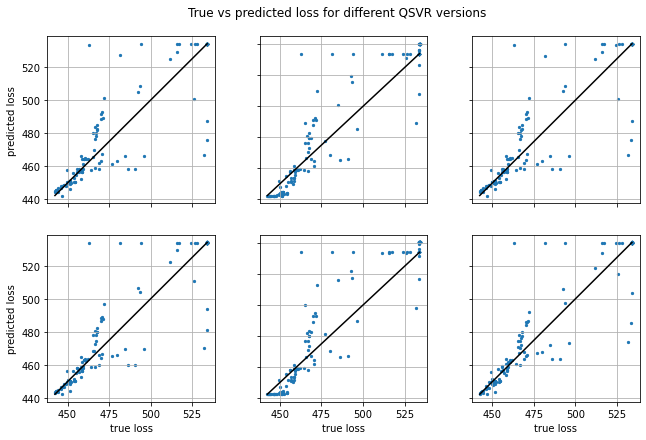

In [76]:
fig, axs = plt.subplots(2,3,figsize=(9, 6))
fig.suptitle("True vs predicted loss for different QSVR versions")
fig.tight_layout()

for ax in axs.flat:
    ax.set(xlabel='true loss', ylabel='predicted loss')
    ax.grid()

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

x = y_scaler.inverse_transform(y_test.reshape(-1, 1))

for i in range(y_pred.shape[0]):
    y = y_scaler.inverse_transform(y_pred[i,:].reshape(-1, 1))
    axs.flat[i].scatter(x,y,s=5)
    axs.flat[i].plot([x.min(),x.max()],[x.min(),x.max()],'k')

plt.show()

### Example loading a saved model

In [86]:
sufix = '_2022_08_18-02:08:37.344989_PM' # write the date extension of the model you want to load
#ld_x_scaler = load("x_scaler_q"+sufix+".joblib") 
#ld_y_scaler = load("y_scaler_q"+sufix+".joblib")
ld_qsvr_attrs = load( "qsvr_attrs"+sufix+".joblib")
print(f'B = {ld_qsvr_attrs["B"]}')
print(f'K = {ld_qsvr_attrs["K"]}')
print(f'epsilon = {ld_qsvr_attrs["epsilon"]}')
print(f'best_gamma = {ld_qsvr_attrs["best_gamma"]}')
print(f'best_C = {ld_qsvr_attrs["best_C"]}')

B = 2
K = 3
epsilon = 0.02
best_gamma = 0.1
best_C = 67.61


In [26]:
# instantiate a QSVR that can be used to do predictions
pred_model = QSVR.QSVR() 
# set the QSVR attributes needed for predictions
for attr in ld_qsvr_attrs.keys():
    setattr(pred_model, attr, ld_qsvr_attrs[attr])

# use the QSVR to do a prediction
# loaded scalers may be needed
y_pred = pred_model.predict(X_test)

# make use of the prediction
r2 = []
for i in range(y_pred.shape[0]):
    r2.append(r2_score(y_pred[i],y_test))
r2

[0.902828053334424,
 0.9123044591285047,
 0.9029195202470672,
 0.9124470278391059,
 0.9123044591285047,
 0.8487914544304758]